<a href="https://colab.research.google.com/github/nhatduong01/SQL_on_BigQuery/blob/main/Basis/Chicago_taxi_trips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## We will work on the `chicago_taxi_trips` dataset.

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
# Set up the Project Environment
import os
os.environ["GCLOUD_PROJECT"] = "BigQuerySQLExercises"

In [3]:
from google.cloud import bigquery
import pandas as pd


client = bigquery.Client()

data_ref = client.dataset(dataset_id= 'chicago_taxi_trips',
                          project = "bigquery-public-data")
dataset = client.get_dataset(data_ref)
tables = list(client.list_tables(dataset))

for table in tables:
  print(table.table_id)

taxi_trips


In [4]:
table_ref = data_ref.table('taxi_trips')

table = client.get_table(table_ref)
# Print table schema
table.schema

[SchemaField('unique_key', 'STRING', 'REQUIRED', 'Unique identifier for the trip.', ()),
 SchemaField('taxi_id', 'STRING', 'REQUIRED', 'A unique identifier for the taxi.', ()),
 SchemaField('trip_start_timestamp', 'TIMESTAMP', 'NULLABLE', 'When the trip started, rounded to the nearest 15 minutes.', ()),
 SchemaField('trip_end_timestamp', 'TIMESTAMP', 'NULLABLE', 'When the trip ended, rounded to the nearest 15 minutes.', ()),
 SchemaField('trip_seconds', 'INTEGER', 'NULLABLE', 'Time of the trip in seconds.', ()),
 SchemaField('trip_miles', 'FLOAT', 'NULLABLE', 'Distance of the trip in miles.', ()),
 SchemaField('pickup_census_tract', 'INTEGER', 'NULLABLE', 'The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.', ()),
 SchemaField('dropoff_census_tract', 'INTEGER', 'NULLABLE', 'The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips.', ()),
 SchemaField('pickup_community_area', 'INTEGER', 'NULLABLE', '

In [ ]:
#List the first 10 rows
client.list_rows(table, max_results= 10).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,d7142baead61226e1f0d5fbb42053148d4ea1234,83509dee15087de780f4ceef090a6d37029553d45b193c...,2013-12-28 01:00:00+00:00,2013-12-28 01:00:00+00:00,NaN,0.0,None,None,None,None,8.85,0.00,0.0,0.0,8.85,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
1,c4b5ecbc1199c68bc7c7336502d51c7af3a6f6dd,d6e1a9e103336c396201abe9ceb00795fcd41e14ccbf54...,2014-01-07 10:00:00+00:00,2014-01-07 09:45:00+00:00,NaN,0.0,None,None,None,None,6.45,1.29,0.0,0.0,7.74,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
2,5122fd569680033efac6d8d1990fa60014f112b7,23d5d31d196f02492dee2d0a37f4f52cce7904302213d4...,2014-07-01 20:15:00+00:00,2014-07-01 20:15:00+00:00,0.0,0.0,None,None,None,None,27.00,0.00,0.0,0.0,27.00,Credit Card,Park Ridge Taxi and Livery,None,None,None,None,None,None
3,556af535d64bc6460244a5bad92966fd5d85421f,442f4c9dd3dde549a82c2dc0ef65b85e54664aa28f5b55...,2014-01-07 13:30:00+00:00,2014-01-07 13:30:00+00:00,0.0,0.0,None,None,None,None,5.65,2.00,0.0,0.0,7.65,Credit Card,Taxi Affiliation Services,None,None,None,None,None,None
4,bb1f95719e77f9c887912b7b2ac4aa4b4b1a6bcb,01cfdf564af1a522661ba984b93574d481b54e27516833...,2014-01-25 21:15:00+00:00,2014-01-25 21:00:00+00:00,NaN,0.0,None,None,None,None,10.45,1.00,0.0,0.0,11.45,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
5,fb2e67a5698cd6cae6aa10e51b19c2136e138633,31af69ed89cd6d3c48818cb0ba3541db71149cc4fd3c54...,2014-01-09 23:30:00+00:00,2014-01-09 23:30:00+00:00,NaN,0.0,None,None,None,None,9.25,1.85,0.0,0.0,11.10,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
6,44baf127a93e28605be8735aaa4696a1f638ee94,bb90b2306d04496af0bd28b855103080054c6c38bbbe8e...,2013-07-02 15:30:00+00:00,2013-07-02 15:45:00+00:00,1020.0,0.1,None,None,None,None,10.25,0.00,0.0,0.0,10.25,Cash,Northwest Management LLC,None,None,None,None,None,None
7,76abdca4021065f2c1ba389451ef6b48c6957182,f55fc54d4cd33400f3960410558b28108a78da12682850...,2014-07-24 11:45:00+00:00,2014-07-24 11:45:00+00:00,0.0,0.0,None,None,None,None,7.65,2.00,0.0,0.0,9.65,Credit Card,T.A.S. - Payment Only,None,None,None,None,None,None
8,4bb2b0eba4755390ebff3a2179d321775ce1f6f3,4686819f6124b6c78dfa37266df9dae85c093ba2d24844...,2013-12-14 18:30:00+00:00,2013-12-14 18:30:00+00:00,600.0,0.0,None,None,None,None,10.65,0.00,0.0,0.0,10.65,Cash,Blue Ribbon Taxi Association Inc.,None,None,None,None,None,None
9,0e9aa05e6aa37c94d4bd61d64737da8696866d86,9ed3d450497cbb3cb1093ac395f7b7b2a9830718003318...,2014-01-08 20:00:00+00:00,2014-01-08 20:00:00+00:00,60.0,0.0,None,None,None,None,10.75,2.15,0.0,0.0,12.90,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None


### 1) Determine where the data is from:  
We write a query that returns number of trips in each year.  
The data returned should have two columns:
- `year`
- `num_trips`

In [ ]:
query1 = """
         SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year, COUNT(1)
         AS num_trips
         FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
         GROUP BY year
         ORDER BY num_trips"""
query_job1 = client.query(query = query1, project = 'bigquerysqlexercises')

year_trips = query_job1.to_dataframe()
year_trips

,year,num_trips
0,2021,1343776
1,2020,3889032
2,2019,16477365
3,2018,20732088
4,2017,24988003
5,2013,27217716
6,2016,31759339
7,2015,32385875
8,2014,37395436


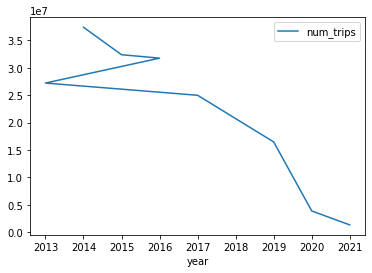

In [ ]:
year_trips.plot( x = 'year', y = 'num_trips')

### 2) Day tendency:
We may want to see which day in the week people usually go by taxi.

In [ ]:
query2 = """
         SELECT EXTRACT (YEAR FROM trip_start_timestamp) AS year,
         EXTRACT (DAYOFWEEK FROM trip_start_timestamp) AS day,
         COUNT(1) AS num_trips
         FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
         GROUP BY year, day"""
query_job2 = client.query(query2, project= 'bigquerysqlexercises')

day_tendency = query_job2.to_dataframe()
day_tendency

,year,day,num_trips
0,2013,6,4565165
1,2021,7,171834
2,2016,7,4602931
3,2015,1,4141154
4,2017,4,3870833
...,...,...,...
58,2018,4,3212651
59,2017,2,3240334
60,2017,6,4131260
61,2019,4,2638105


In [ ]:
# Get the value of 2018 sorted by day of week
data_2018 = day_tendency.loc[day_tendency.year == 2018].sort_values(by = 'day')

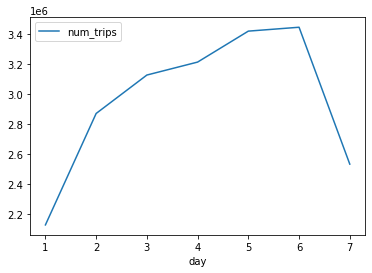

In [ ]:
data_2018.plot(x = 'day', y = 'num_trips')

$\rightarrow$ From the observation of 2018, 2017, 2016. **Friday** is the day people use taxi the most.

### 3) Speed tendency:
We want write a query that shows, for each hour of the day in the dataset, the corresponding number of trips and average speed.

The results should have three columns:
- `hour_of_day` - sort by this column, which holds the result of extracting the hour from `trip_start_timestamp`.
- `num_trips` - the count of the total number of trips in each hour of the day (e.g. how many trips were started between 6AM and 7AM, independent of which day it occurred on).
- `avg_mph` - the average speed, measured in miles per hour, for trips that started in that hour of the day.  Average speed in miles per hour is calculated as `3600 * SUM(trip_miles) / SUM(trip_seconds)`. (The value 3600 is used to convert from seconds to hours.)

Restrict the query to data meeting the following criteria:
- a `trip_start_timestamp` between **2017-01-01** and **2017-07-01**
- `trip_seconds` > 0 and `trip_miles` > 0


In [8]:
query3 = """
        WITH raw_table AS
        (
        SELECT EXTRACT(HOUR from trip_start_timestamp) AS hour_of_day,
        trip_seconds, trip_miles
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE trip_miles > 0 AND trip_seconds > 0 AND
        trip_start_timestamp > '2017-01-01' AND 
        trip_start_timestamp < '2017-07-01'
        )
        SELECT hour_of_day, COUNT(1) AS num_trips, 
        3600*SUM(trip_miles)/SUM(trip_seconds) as avg_mph
        FROM raw_table
        GROUP BY hour_of_day
        ORDER BY avg_mph DESC
         """
query_job3 = client.query(query = query3, project = 'bigquerysqlexercises')

raw_data = query_job3.to_dataframe()
raw_data

,hour_of_day,num_trips,avg_mph
0,5,119312,30.769172
1,4,122183,26.736014
2,6,182738,24.588313
3,21,552726,20.433874
4,0,319339,20.230524
5,3,159668,20.158048
6,23,399587,19.877046
7,20,598614,19.536777
8,22,501095,19.531374
9,1,266529,18.937621


_In Conclusion :_
- The taxi driver drives at fastest speed at 5 a.m.
- The taxi driver receives most calls at 6 p.m.